# NB. Linear Stability Analysis Using Orr-Sommerfeld Equation

> Philipp Schlatter and Saleh Rezaeiravesh <br />
  pschlatt@mech.kth.se and salehr@kth.se <br />
  SimEx/FLOW, KTH Engineering Mechanics, Royal Institute of Technology, Stockholm, Sweden

> This notebook is a part of the [KTH-Nek5000 lecture notes](https://kth-nek5000.github.io/kthNekBook/).


In this notebook, we will discuss what one can do with the Orr-Sommerfeld equations for channel flow. 
In particular, we will first perform classical modal stability analysis, by deriving the discretised system matrix followed
by an eigenvalue analysis; we will also plot the neutral curve. Then we will perform non-modal stability analysis, deriving 
transient growth and other interesting things such as numerical abscissa.

All this is done on the example of plane Poiseuille flow (channel flow), but can be adapted easily to other base flows. 
The equations are discretised in space using a Chebyshev collocation method where the boundary conditions are kept
explicitly for simplicity.

In [1]:
#%matplotlib notebook
%matplotlib inline
import sys
import numpy as np
import scipy.linalg as scla
import matplotlib.pyplot as plt
import math as mt
import matplotlib.pylab as pylab
from chebdif import chebdif
from GLC_pwts import GLC_pwts
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (8,6),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 17,
          'axes.titlesize': 17,
          'xtick.labelsize':15,
          'ytick.labelsize':15,
          'grid.alpha':0.6}
pylab.rcParams.update(params)

## 1. Governing equations

### Orr-Sommerfeld equation

In this notebook, the Orr-Sommerfeld equation is numerically solved for the laminar channel flow. The differentiations are approximated by the Chebyshev method which is discussed in a separate notebook. 

The Orr-Sommerfeld equation for linear stability analysis in two dimensions can be derived as, 

$$
\begin{equation}
(U-c)(\hat{v}'' -\alpha^2 \hat{v})-\hat{v} U''=-\frac{i}{\alpha Re}(\hat{v}''''-2\alpha^2 \hat{v}'' +\alpha^4 \hat{v}) \,,
\end{equation}
$$

where $\hat{v}=\hat{v}(y)$, $U(y)$ is the velocity profile, $Re$ denotes Reynolds number, $\alpha$ is the wavenumber, and $c=\omega/\alpha$ is the phase speed for a circular frequency $\omega$. 
All derivatives are with respect to the spatial coordinates $y$ where $y\in[-1,1]$. Using our formulation, the velocity ansatz is

$$
v(x,y,z,t) = \hat{v}(y)\,\exp(i \alpha x + i \beta z)\,\exp(-i \omega t) \, ,
$$

where the temporal exponential can be written with $\sigma = -i \omega$ as

$$
\exp(-i \omega t) = \exp ( \sigma t) \, .
$$

We can now also consider the three-dimensional case with $\beta\neq0$. Introducing the differentiation operator $D$, where $\hat{v}^{(n)} = D^n \hat{v}$, and the wavenumber $k^=\alpha^2 + \beta^2$ leads to, 

$$
\underbrace{\left[ -\frac{1}{Re}\left(D^2-k^2 I\right)^2 -i \alpha U'' + i\alpha U (D^2-k^2I)
\right]}_{A_{OS}} \hat{v}
=
\omega\, \underbrace{i (D^2-\alpha^2 I)}_{B_{OS}} \hat{v}
$$

using $\omega=c \alpha$. The system can now be written as, 

$$
A_{OS}\hat{v} = \omega B_{OS}\hat{v} \,.
$$

This equation defines a **generalized eigenvalue problem**. Since $B$ can be inverted, we can also write

$$B_{OS}^{-1} A_{OS} \hat{v} = L_{OS}\hat{v} = \omega \hat{v} = i \sigma \hat{v} \, . $$

### Squire equation

In a similar way, an equation for the wall-normal vorticity $\eta$ can be derived. We obtain for the general 3D case

$$
\underbrace{\left[ -\frac{1}{Re}\left(D^2-k^2 I\right)  + i\alpha U 
\right]}_{A_{SQ}} \hat{\eta}\quad \underbrace{+ i \beta U' \hat{v}}_{C_{SQ}}
=
\omega\, \underbrace{i}_{B_{SQ}} \hat{\eta}  \ .
$$

The Orr-Sommerfeld and Squire equations can be combined in one matrix equation

$$
  \left[ {\begin{array}{cc}
    A_{OS} & 0 \\
    C_{SQ} & A_{SQ} \\
  \end{array} } \right]  
  \cdot 
  \left(
  {\begin{array}{c}
  \hat{v} \\
  \hat{\eta} \\
  \end{array} }
  \right)
 =
  \omega \left[ {\begin{array}{cc}
    B_{OS} & 0 \\
    0 & B_{SQ} \\
  \end{array} } \right]  
  \cdot 
  \left(
  {\begin{array}{c}
  \hat{v} \\
  \hat{\eta} \\
  \end{array} }
  \right)
 $$
 
 or in more compact form:
 
 $$
 A \hat{q} = \omega B \hat{q} 
 $$
 and finally
 $$
 B^{-1} A \hat{q} = L\hat{q} = \omega \hat{q} = i \sigma \hat{q} \, .
 $$

In the section below, the various matrices are explicitly derived, supplemented with boundary conditions, and the eigenvalue problem is solved.


---
## 2. Discrete temporal stability analysis
For given $Re$, $\alpha$ and $\beta$, the Orr-Sommerfeld equation can be solved for the laminar channel flow with $U(y)=1-y^2$. As a result, the eigenvalues $\omega \in \mathbb{C}$ and associated eigenfunctions $\hat{v}(y)$ are computed. 

**Set the solution parameters:**

In [2]:
Re = 1000    # Re_cl
alpha= 1   # streamwise wavenumber
beta = 1   # spanwise wavenumber
N=150        # resolution
k2 = alpha**2 + beta**2

**Construct the differentiation operators:**
The differential opertors are approximated by the Chebyshev method. As described in the Chebyshev notebook, we use a generalized formulation of the Chebyshev differentiation matrix as applied in `chebdif.m`, see [Weideman and Reddy](https://web.iitd.ac.in/~mmehra/MATH4Q03/ft_gateway.cfm.pdf). A Python version of `chebdif.m` which is used here is taken from [dmsuite](https://github.com/ronojoy/pyddx/blob/master/sc/dmsuite.py), but small modifications have been applied. 

In [3]:
y,D_=chebdif(N,1)
D=D_[0,:,:]
D2=D@D
D4=D2@D2

**Construct the base flow:** Compute the base flow for Poiseuille flow (in this case), together with the first and second derivatives. We also compute the centre-line velocity $U_{cl}$ and the bulk velocity $U_b$ using Clenshaw-Curtis integration.

In [4]:
Uvel=np.zeros([N,3])
Uvel[:,0] = 1-y**2
Uvel[:,1] = -2*y
Uvel[:,2] = -2

yy,wcc=GLC_pwts(N)
Ucl = 1
Ubulk = wcc.T@Uvel[:,0]/2

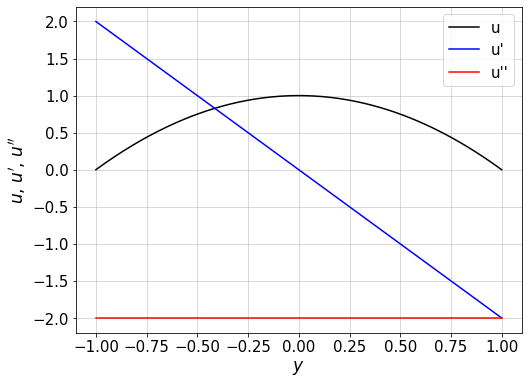

In [5]:
plt.figure()
plt.plot(y,Uvel[:,0],'k',label="u")
plt.plot(y,Uvel[:,1],'b',label="u'")
plt.plot(y,Uvel[:,2],'r',label="u''")
plt.legend(loc='best')
plt.xlabel(r'$y$')
plt.ylabel(r"$u$, $u'$, $u''$")
plt.grid()
plt.show()

**Construct the Orr-Sommerfeld operators A and B**: 

Put together the various matrix components and set the boundary conditions:
$$
\hat{v}(y=\pm 1) =0 \,,\quad\quad \hat{v}'(y=\pm 1) = 0
$$

and

$$
\hat{\eta}(y=\pm 1) =0 \ .
$$

The solution vector is the combination of $\hat{v}$ and $\hat{\eta}$, i.e. $\hat{q} = [\hat{v}\  \hat{\eta}]^T$.

In [6]:
# [ A_OS   0  ] [ vhat ]         [ B_OS  0 ]*[ vhat ] 
# [           ]*[      ] = omega*[         ]*[      ]
# [ C_SQ A_SQ ] [etahat]         [  0   B_SQ]*[etahat]
#
#  A qhat = omega B qhat

I = np.identity(N)
O = np.zeros((N,N))
delta = (D2-I*k2)
delta2 = D4-2*D2*k2+I*k2**2
A_OS = -delta2/Re - 1j*alpha*np.diag(Uvel[:,2]) + 1j*alpha*np.diag(Uvel[:,0])@delta
B_OS = 1j*delta

A_SQ = 1j* alpha*np.diag(Uvel[:,0]) - delta/Re;
B_SQ = 1j*I
C_SQ = beta*np.diag(Uvel[:,1]) 

# move the eigenvalues of the BC to Q
Qeig=-999j

# two homogeneous Dirichlet conditions
A_OS[0,:] = Qeig*I[0,:]
B_OS[0,:] = I[0,:]
A_OS[N-1,:] = Qeig*I[-1,:]
B_OS[N-1,:] = I[-1,:]

# two homogeneous Dirichlet conditions
A_SQ[0,:] = Qeig*I[0,:]
B_SQ[0,:] = I[0,:]
A_SQ[N-1,:] = Qeig*I[-1,:]
B_SQ[N-1,:] = I[-1,:]

# two homogeneous Neumann conditions
A_OS[1,:] = Qeig*D[0,:]
B_OS[1,:] = D[0,:]
A_OS[N-2,:] = Qeig*D[-1,:]
B_OS[N-2,:] = D[-1,:]

# compose big matrix
A = np.vstack( (np.hstack((A_OS,O)),np.hstack((C_SQ,A_SQ))))
B = np.vstack( (np.hstack((B_OS,O)),np.hstack((O,B_SQ))))

When the boundary conditions are implemented, both $A$ and $B$ should be full rank:

In [7]:
np.linalg.matrix_rank(A),np.linalg.matrix_rank(B)

(300, 300)

Now we can construct the complete system matrix $L_c$ (denoted `Lc` in the code), and solve the eigenvalue problem. Our formulation is

$$ L_c \hat{q} = \omega_c \hat{q} \quad \text{or} \quad L_c U = U \omega_c \, ,$$

and the eigenvalues are denoted $\omega_c$, and the eigenvectors $U$, respectively. We thus have

$$ L_c = U \omega_c U^{-1} \, .$$

We then sort the eigenvalues/eigenvectors according to the eigenvalues' imaginary part.

In [8]:
# compute eigenvalues and eigenvectors (A*vhat = omega*B*vhat)
# omega,vv = scla.eig(A,B)

Lc=np.linalg.inv(B) @ A
omegac,U = np.linalg.eig(Lc)

# sort eigenvalues
isort=np.argsort(-np.imag(omegac))
omegac=omegac[isort]
U=U[:,isort]

# identify high-frequency modes
#for i in range(0,omegac.size):
#    if np.abs(np.real(omegac[i]))>500:
#        omegac[i]=2*Q      

# set the eigenvectors pertaining to the boundary conditions to zero
#for i in range(0,omegac.size):
#    if (np.imag(omegac[i]))<-998:
#        U[:,i]= 0

---
## 3. Modal stability analysis

Based on the above Orr-Sommerfeld operator, we extract leading eigenvalue and its eigenfunction (TS wave). Each eigenfunction has a specific symmetry which is evaluated and stored in the `prop` arrays

In [9]:
omega_max = -100j
ii=-100

# properties for each eigenvector: 0: sum, 1: zero if symmetric, 2: zero if antisymmetric
propu=np.zeros((3,2*N))
propv=np.zeros((3,2*N))
propw=np.zeros((3,2*N))
prope=np.zeros((3,2*N))
for i in range(0,omegac.size):
    
    v   = U[0:N,i]
    eta = U[N:2*N,i]
    u = (1j/k2)*(alpha*np.dot(D,v) - beta*eta) 
    w = (1j/k2)*(alpha*eta + beta*np.dot(D,v))
    
    propu[0,i]=np.sum(np.abs(u))
    propu[1,i]=np.sum(np.abs(u-u[N-1:None:-1]))
    propu[2,i]=np.sum(np.abs(u+u[N-1:None:-1]))
    propv[0,i]=np.sum(np.abs(v))
    propv[1,i]=np.sum(np.abs(v-v[N-1:None:-1]))
    propv[2,i]=np.sum(np.abs(v+v[N-1:None:-1]))
    propw[0,i]=np.sum(np.abs(w))
    propw[1,i]=np.sum(np.abs(w-w[N-1:None:-1]))
    propw[2,i]=np.sum(np.abs(w+w[N-1:None:-1]))
    prope[0,i]=np.sum(np.abs(eta))
    prope[1,i]=np.sum(np.abs(eta-eta[N-1:None:-1]))
    prope[2,i]=np.sum(np.abs(eta+eta[N-1:None:-1]))
      
    if np.imag(omegac[i])>np.imag(omega_max):
        if np.real(omegac[i]<0.8*alpha):
            omega_max=omegac[i]
            ii = i

v   = U[0:N,ii]
eta = U[N:2*N,ii]

# use continuity and definition of eta
# u = i/k^2 ( alpha D v - beta * eta)
# w = i/k^2 ( alpha eta + beta D v)

u = (1j/k2)*(alpha*np.dot(D,v) - beta*eta) 
w = (1j/k2)*(alpha*eta + beta*np.dot(D,v))

print('Leading eigenvalue omega = ',omega_max)

Leading eigenvalue omega =  (0.4277627901151306-0.03703786207561911j)


The structure of the $L_c$ matrix shows that there is the Orr-Sommerfeld operator is independent from the Squire operator. The latter connects to the OS operator via a diagonal matrix in the lower-left corner.

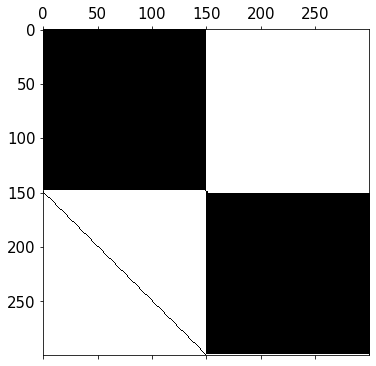

In [10]:
plt.spy(Lc)
plt.show()

We scale the eigenfunctions such that the maximum of the streamwise velocity is unity:

In [11]:
i=np.argmax( abs(u[0:int(N/2)]))
uscale=u[i]
u/=uscale
v/=uscale
w/=uscale
eta/=uscale

Finally, we can plot the spectrum consisting of the eigenvalues $\omega_c$. The typical Orr-Sommerfeld spectrum appears with the known branches. For Poiseuille flow, the frequency $\omega$ ranges between 0 and $U_{cl} \alpha$ without any symmtery. The bulk velocity appears as a vertical line at $\omega = U_b \alpha$:

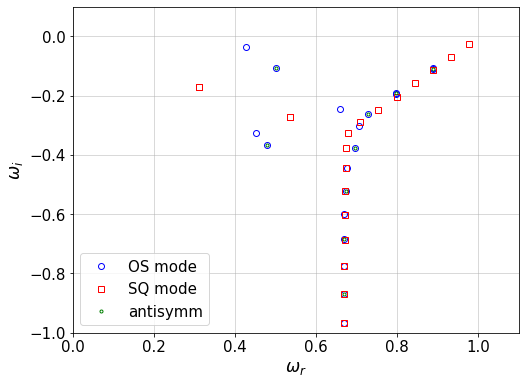

vertical branch omega=0.66667


In [12]:
plt.figure()
#plt.plot(omegac.real,omegac.imag,'ob')
i_squire = np.argwhere(np.abs(propv[0,:])<1e-5)
i_nsquire = np.argwhere(np.abs(propv[0,:])>1e-5)
i_asymm = np.argwhere(np.abs(propv[1,:])>1e-5)
plt.plot(omegac[i_nsquire].real,omegac[i_nsquire].imag,'ob',label='OS mode')
plt.plot(omegac[i_squire].real,omegac[i_squire].imag,'sr',label='SQ mode')
plt.plot(omegac[i_asymm].real,omegac[i_asymm].imag,'.g',label='antisymm')
plt.xlim([0,alpha*1.1])
plt.ylim([-1,0.1])
plt.grid()
plt.xlabel('$\omega_r$')
plt.ylabel('$\omega_i$')
plt.legend(loc='lower left')
plt.show()
print("vertical branch omega=%.5f" % (Ubulk*alpha))

**Plot amplitude of the perturbations**

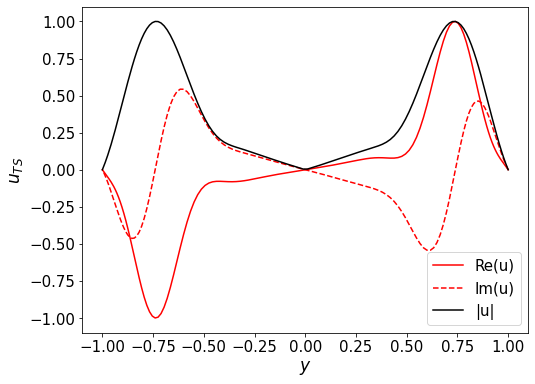

In [13]:
plt.figure()
plt.plot(y,u.real,'r',label='Re(u)')
plt.plot(y,u.imag,'r--',label='Im(u)')
plt.plot(y,abs(u),'k-',label='|u|')
plt.legend(loc='best')
plt.xlabel(r'$y$')
plt.ylabel(r'$u_{TS}$')
plt.show()

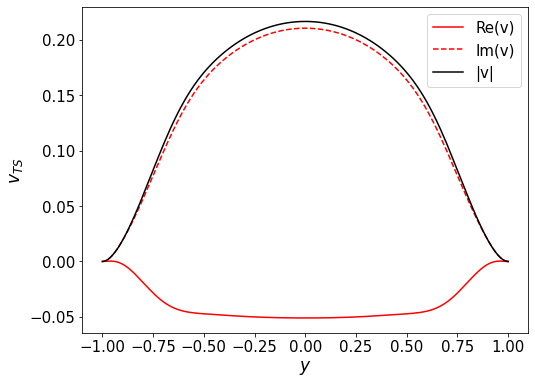

In [14]:
plt.figure()
plt.plot(y,v.real,'r',label='Re(v)')
plt.plot(y,v.imag,'r--',label='Im(v)')
plt.plot(y,abs(v),'k-',label='|v|')
plt.xlabel(r'$y$')
plt.ylabel(r'$v_{TS}$')
plt.legend(loc='best')
plt.show()

In [15]:
propv[:,i]

array([1.76497007e-01, 3.52994015e-01, 4.24813790e-11])

---
## 4. Transient growth analysis


We formulate the stability problem as an input-output problem. We use the previously introduced matrix $L$

$$
\frac{\partial \tilde{q}}{\partial t} = - i L \tilde{q}
$$

where $\tilde{q} = \tilde{q}(y,t)$. The solution can now be written using a matrix exponential

$$
\tilde{q}(t) = \exp (-i L t) \tilde{q}_0 \quad \Rightarrow \quad \tilde{q}(t) = B \tilde{q}_0 
$$

with $B=\exp ( -iLt)$. Using the definition of the matrix exponential,

$$
\exp(X) = \sum_{j=0}^{\infty} \frac{1}{j!} X^j \, ,
$$

we can simplify $B$ with the eigendecomposition of $L=U \omega U^{-1}$ as follows

$$
B= \exp ( -iLt) = \exp ( -i U \omega U^{-1} t ) = U \exp(-i\omega t) U^{-1} \ .
$$

With this, we can define a energy growth $G(t)$ due to the action of $B$ as a matrix norm $||B||$:

$$G(t) =\max_{q_0} \frac{|q(t)|^2}{|q_0|} = \max_{q_0} \frac{|B q_0|^2}{|q_0|} = ||B||
$$

We thus see that the growth of energy is

$$G(t) = || U \exp(-i \omega t) U^{-1}  || $$

If $U$ and $U^{-1}$ are unitary, i.e. we deal with a normal matrix $L$, then $G(t) = | \exp(-i \omega t)|$. In all other cases, for small times, $U$ and $U^{-1}$ may contribute to the norm, and lead to _transient growth_.

Recall that for a orthogonal (orthonormal) matrix $R^H R = I$. A normal matrix $R^H R = R R^H$ can be diagonalised by unitary matrices.

The level of non-normality can be measuered by the condition number of $U$, i.e.

$$\kappa(U) = ||U||^2 ||U^{-1}||^2$$

For $\kappa(U)=1$ there is no transient growth, i.e. the system is normal.

In [16]:
np.linalg.cond(U)

446860506836547.2

We compute the integration weights for the Chebyshev points $W$ using the Clenshaw-Curtis weights:

In [17]:
yy,wcc=GLC_pwts(N)
W = np.diag(wcc)

We use the following energy norm 
$$ ||\mathbf{v}||^2 = \frac1{2k^2} \int_{-1}^1 \left( |\mathrm{D} \hat{v}|^2 + k^2 |\hat{v}|^2 + |\hat{\eta}|^2  \right) \mathrm{d} y $$ which can be derived using continuity and the definition of the vorticity (Gustavsson 1986). 

We thus define the corresponding weight matrix $\mathbf{Q}$
which can be used for the discrete evaluation of the energy norm $\hat{q}^T Q \hat{q}$ pertaining to a vector $\hat{q}$. The structure of the weight matrix $Q$ shows a full submatrix in the upper-right corner, and a diagonal matrix in the lower-left corner. 

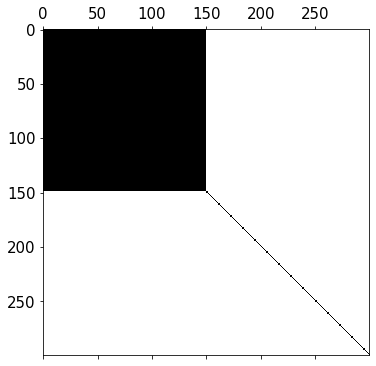

In [18]:
Q=np.vstack( (np.hstack((0.5*D.T @ W @ D/k2 + 0.5*W,O)),
              np.hstack((O,0.5/k2*W))))
plt.spy(Q)
plt.show()

In [19]:
# not used here, but we could also compute the "square-root" Qsq of Q=QsqT Qsq to multiply a vector x with:
# y = Qsq x
# such that the 2-norm of y becomes the same as the Q-norm of x: 
# yT y = (Qsq x)T Qsq x = xT QsqT Qsq x = xT Q x.
# This is possible because Q is Hermitian (self-adjoint, check np.allclose(Q,Q.conj().T)
V,S,__ = np.linalg.svd(Q)
Qsq = np.diag(np.sqrt(S)) @ V.conj().T
Qsqinv = V@np.diag(1./np.sqrt(S))
np.allclose(Qsq.conj().T@Qsq,Q)

True

We restrict now the number of eigenvalues/eigenmodes to be considered further by only choosing the $imax$ most growing modes where $\omega_i>-1.5$. These eigenmodes are denoted as the relevant eigenvalues, $\omega_{rel}$ or `omrel` with the corresponding relevant eigenmodes `Urel`.

In [20]:
imax = 0
for ii in range(0,2*N):
    if np.imag(omegac[ii])>-1.5:
        imax=ii

Urel = U[:,0:imax]
omrel = omegac[0:imax]

# imax = omegac.size   # we take all modes: imax = omega.size

print('We use %i eigenmodes out of %i.' % (imax,2*N))

We use 46 eigenmodes out of 300.


Based on the reduced system, compute the energy-weighted eigenvectors. We first compute the energy of the eigenmodes $E$

In [21]:
E = Urel.conj().T @ Q @ Urel

Factorise $E$ into $E=F^H F$ using SVD, that is $E=V \Sigma V^H$, and $F=\sqrt{\Sigma} V^H$. Note that this is possible because $E=E^H$ is Hermitian. We also compute $F^{-1}=V \sqrt{\Sigma}^{\, -1}$. Note that in `numpy` the third argument is already the Hermitian transpose (as opposed to Matlab).

In [22]:
Vexp, Sexp, Wexp = np.linalg.svd(E)
F    = np.diag(np.sqrt(Sexp))@Vexp.conj().T
Finv = Vexp@np.diag(1./np.sqrt(Sexp))

Now we have $E=U_r^H Q U_r = F^H F$, such that the $F$ include the (square-root of the) energy weight $Q$. We can build a reduced system $L=F \omega_{rel} F^{-1}$

In [23]:
L=F@np.diag(omrel)@Finv

As expected, this reduced matrix has the same eigenvalues as the original system matrix for the chosen subset of modes, and $F$ are the eigenvectors. 

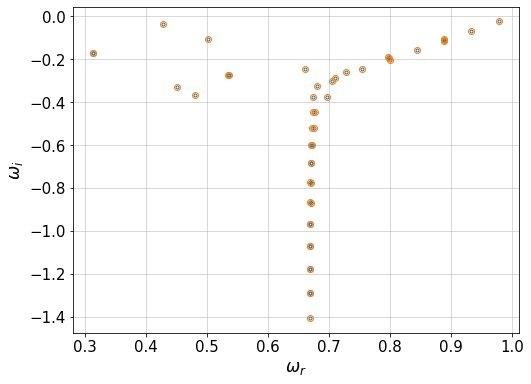

In [24]:
t1,t2=np.linalg.eig(L)

plt.plot(np.real(omrel),np.imag(omrel),'.')
plt.plot(np.real(t1),np.imag(t1),'o')
plt.grid()
plt.xlabel('$\omega_r$')
plt.ylabel('$\omega_i$')
plt.show()

Now we can evaluate the largest growth at a given time by considering the matrix $B(t) = F \exp ( -i \omega_{rel} t) F^{-1}$. The energy at time $t$ is $(B q_0)^H (B q_0) = q_0 B^H B q_0$ (without $Q$ as the weights are already included in $F$). To find the largest growth, we need to find the strongest eigenvalue of $B^H B$. This value can be found as the square of the largest singular value of $B$. The corresponding eigenvectors/singluar vectors give the initial and final vectors, respectively. In case $B$ is not explicitly available, power iterations with a forward evaluation (corresponding to $B$) followed by an adjoint evaluation (corresponding to $B^H$) is possible.

In [25]:
maxtime = 250
ntime = 101
tvec = np.linspace(0,maxtime,ntime)
q0 = np.zeros((2*N,ntime),dtype=complex)
qmax = np.zeros((2*N,ntime),dtype=complex)
maxgrowth = np.zeros((ntime))

In [26]:
for it in range(0,ntime):
    time=tvec[it]
    uopt,sopt,vopt = np.linalg.svd(F@np.diag(np.exp(-1j*omrel*time))@Finv)
    vopt = vopt.conj().T
    q0[:,it] = Urel@Finv@vopt[:,0]
    qmax[:,it] = Urel@Finv@uopt[:,0]
    maxgrowth[it] = sopt[0]**2
    print("time=%.5f amp=%.5e" % (time,maxgrowth[it]))  
imax = np.argmax(maxgrowth)
Gmax = maxgrowth[imax]
tmax = tvec[imax]
print("max growth Gmax=%.5f at t=%.5f" % (Gmax,tmax))

time=0.00000 amp=1.00000e+00
time=2.50000 amp=2.95003e+00
time=5.00000 amp=7.01651e+00
time=7.50000 amp=1.31335e+01
time=10.00000 amp=1.99763e+01
time=12.50000 amp=2.54844e+01
time=15.00000 amp=2.80216e+01
time=17.50000 amp=2.72462e+01
time=20.00000 amp=2.40693e+01
time=22.50000 amp=1.99101e+01
time=25.00000 amp=1.59180e+01
time=27.50000 amp=1.26397e+01
time=30.00000 amp=1.01332e+01
time=32.50000 amp=8.24024e+00
time=35.00000 amp=6.78224e+00
time=37.50000 amp=5.62726e+00
time=40.00000 amp=4.68752e+00
time=42.50000 amp=3.90569e+00
time=45.00000 amp=3.24758e+00
time=47.50000 amp=2.69506e+00
time=50.00000 amp=2.23602e+00
time=52.50000 amp=1.85723e+00
time=55.00000 amp=1.54399e+00
time=57.50000 amp=1.28333e+00
time=60.00000 amp=1.06595e+00
time=62.50000 amp=8.85252e-01
time=65.00000 amp=7.35547e-01
time=67.50000 amp=6.11437e-01
time=70.00000 amp=5.08222e-01
time=72.50000 amp=4.22268e-01
time=75.00000 amp=3.50799e-01
time=77.50000 amp=2.91485e-01
time=80.00000 amp=2.42252e-01
time=82.50000 

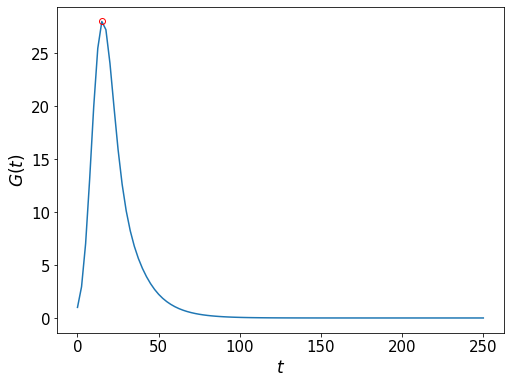

In [27]:
plt.plot(tvec,maxgrowth)
plt.plot(tvec[imax],maxgrowth[imax],'ro')
plt.xlabel('$t$')
plt.ylabel('$G(t)$')
plt.show()

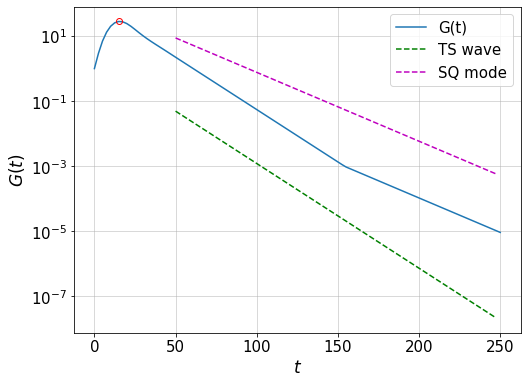

In [28]:
plt.semilogy(tvec,maxgrowth,label='G(t)')
plt.plot(tvec[imax],maxgrowth[imax],'ro')
plt.plot(tvec[20:-1],2*np.exp(2*tvec[20:-1]*np.imag(omegac[1])),'g--',label='TS wave')
plt.plot(tvec[20:-1],100*np.exp(2*tvec[20:-1]*np.imag(omegac[0])),'m--',label='SQ mode')
plt.xlabel('$t$')
plt.ylabel('$G(t)$')
plt.legend(loc='best')
plt.grid()
plt.show()

In [29]:
tvec[imax]

15.0

Some simple checks: $q_0$ and $q_\mathrm{max}$ all have unit energy:

In [30]:
qq=q0[:,imax]
qq.conj().T@Q@qq

(0.9999999999926473-4.969982758673552e-16j)

In [31]:
qq=qmax[:,imax]
qq.conj().T@Q@qq

(0.9999999999999989+6.106226635438361e-16j)

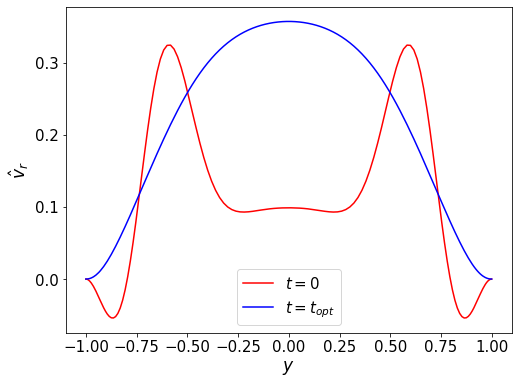

In [32]:
plt.plot(y,np.real(q0[0:N,imax]),'r',label='$t=0$')
plt.plot(y,np.real(qmax[0:N,imax]),'b',label='$t=t_{opt}$')
plt.xlabel('$y$')
plt.ylabel('$\hat{v}_r$')
plt.legend()
plt.show()

We can check the computations but considering the orignal system matrix $L_c$, and computing $q_1 = \exp( -i L_c t) q_0$, and then comparing $G(t)$ with the energy at time $t$ as $E(t)= q_1^T Q q_1$. On can also compare the final vector `qq1`

In [33]:
time=tvec[imax]
qq0=q0[:,imax]
qq1=scla.expm(-1j*Lc*time)@qq0
(np.abs(qq1.conj().T@Q@qq1),maxgrowth[imax])

(28.021587064210664, 28.021587063913124)

In [40]:
qq1/(qmax[:,imax]*np.sqrt(maxgrowth[imax]))

C:\Users\pschl\AppData\Local\Temp\ipykernel_20920\460788883.py:1: RuntimeWarning: invalid value encountered in true_divide
  qq1/(qmax[:,imax]*np.sqrt(maxgrowth[imax]))


array([2.16794449e-05+3.54417435e-05j, 1.48128719e-04-2.83565448e-05j,
       1.48154377e-04-2.83469758e-05j, 1.48197537e-04-2.83306551e-05j,
       1.48258794e-04-2.83070405e-05j, 1.48338991e-04-2.82754046e-05j,
       1.48439224e-04-2.82348694e-05j, 1.48560847e-04-2.81844514e-05j,
       1.48705478e-04-2.81231205e-05j, 1.48875004e-04-2.80498735e-05j,
       1.49071576e-04-2.79638241e-05j, 1.49297597e-04-2.78643101e-05j,
       1.49555702e-04-2.77510193e-05j, 1.49848711e-04-2.76241323e-05j,
       1.50179565e-04-2.74844819e-05j, 1.50551229e-04-2.73337243e-05j,
       1.50966560e-04-2.71745153e-05j, 1.51428131e-04-2.70106824e-05j,
       1.51938007e-04-2.68473804e-05j, 1.52497472e-04-2.66912127e-05j,
       1.53106708e-04-2.65502997e-05j, 1.53764437e-04-2.64342739e-05j,
       1.54467530e-04-2.63541778e-05j, 1.55210615e-04-2.63222456e-05j,
       1.55985699e-04-2.63515531e-05j, 1.56781856e-04-2.64555265e-05j,
       1.57584997e-04-2.66473116e-05j, 1.58377791e-04-2.69390196e-05j,
      

The curve $G(t)$ is the enveloppe of different initial conditions for each time $t$, as can be shown here:

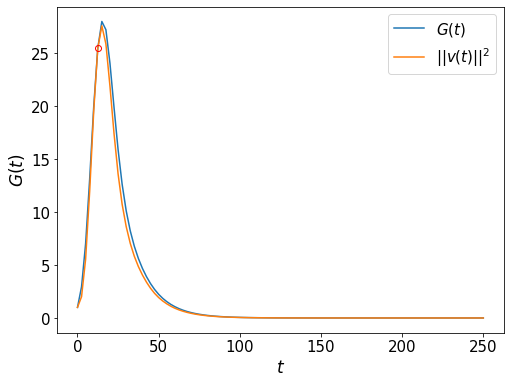

In [35]:
iopt=5
qq0=q0[:,iopt]
en=np.zeros(ntime)
for it in range(0,ntime):
    time=tvec[it]
    qq1=scla.expm(-1j*Lc*time)@qq0
    en[it]=np.real(qq1.conj().T@Q@qq1)
    
plt.plot(tvec,maxgrowth,label='$G(t)$')
plt.plot(tvec,en,label='$||v(t)||^2$')
plt.plot(tvec[iopt],maxgrowth[iopt],'ro')
plt.xlabel('$t$')
plt.ylabel('$G(t)$')
plt.legend(loc='best')
plt.show()

We can also check that everything we did with the integration weights for the energy were actually correct:

In [36]:
qq0=q0[:,imax]          # initial condition
qq0=qmax[:,imax]      # outcome at tmax

v   = qq0[0:N]
eta = qq0[N:2*N]
u = (1j/k2)*(alpha*np.dot(D,v) - beta*eta) 
w = (1j/k2)*(alpha*eta + beta*np.dot(D,v))

In [37]:
qq0.conj().T@Q@qq0

(0.9999999999999989+6.106226635438361e-16j)

In [38]:
0.5*(u.conj().T@W@u + v.conj().T@W@v + w.conj().T@W@w)

(1.000000000000027+1.3877787807814457e-17j)

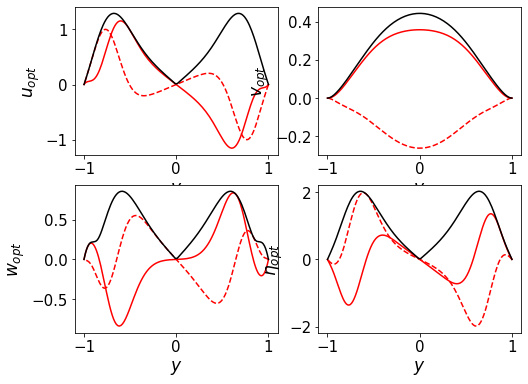

In [39]:
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(y,u.real,'r',label='Re(u)')
axs[0,0].plot(y,u.imag,'r--',label='Im(u)')
axs[0,0].plot(y,abs(u),'k-',label='|u|')
axs[0,0].set(xlabel='$y$',ylabel='$u_{opt}$')

axs[0,1].plot(y,v.real,'r',label='Re(u)')
axs[0,1].plot(y,v.imag,'r--',label='Im(u)')
axs[0,1].plot(y,abs(v),'k-',label='|u|')
axs[0,1].set(xlabel='$y$',ylabel='$v_{opt}$')

axs[1,0].plot(y,w.real,'r',label='Re(u)')
axs[1,0].plot(y,w.imag,'r--',label='Im(u)')
axs[1,0].plot(y,abs(w),'k-',label='|u|')
axs[1,0].set(xlabel='$y$',ylabel='$w_{opt}$')

axs[1,1].plot(y,eta.real,'r',label='Re(u)')
axs[1,1].plot(y,eta.imag,'r--',label='Im(u)')
axs[1,1].plot(y,abs(eta),'k-',label='|u|')
axs[1,1].set(xlabel='$y$',ylabel='$\eta_{opt}$')

plt.show()

### Numerical abscissa

We use now the reduced system matrix $L$ based on the reduced number of eigenvalues, weighted by the energy norm. Now, we compute the numerical abscissa as the principal (real) eigenvalue $\lambda_0$ of $L+L^H$. The value corresponds to the slope of the energy growth $\partial G(t)/\partial t$ at time $t=0$, which can be obtained via a Taylor expansion.

In [40]:
lam,vv = np.linalg.eig( ( (-1j*L)+(-1j*L).conj().T) )
# Since L+L^H is Hermitian, the eigenvalues are purely real
lam = np.real(lam)
#vv = np.real(vv)
# sort eigenvalues
isort=np.argsort(-lam)
lam=lam[isort]
vv=vv[:,isort]

The numerical abscissa $\lambda_0$ corresponds to the slope of $G(t)$ at $t=0$ (note that the accuracy of the finite-difference approximation is quite bad, so to get better results one has to decrease the time step in the optimal computation).

In [41]:
(maxgrowth[1]-maxgrowth[0])/(tvec[1]-tvec[0]), lam[0]

(0.7800102836939249, 0.4534606304462338)

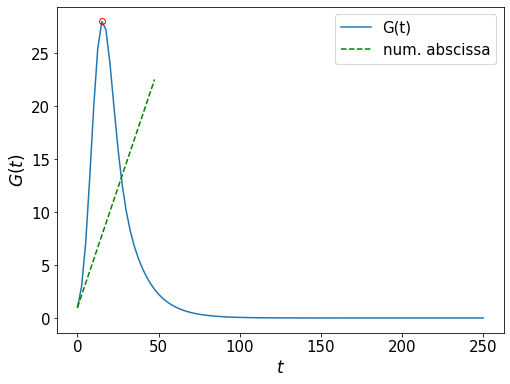

In [42]:
plt.plot(tvec,maxgrowth,label='G(t)')
plt.plot(tvec[imax],maxgrowth[imax],'ro')
plt.plot(tvec[0:20],1+lam[0]*tvec[0:20],'g--',label='num. abscissa')
plt.xlabel('$t$')
plt.ylabel('$G(t)$')
plt.legend(loc='best')
plt.show()

### Numerical range

The numerical range is the generalisation of the numerical abscissa, and corresponds to the maximum amplification due to the matrix $L$.

In [43]:
Ntheta = 100
theta = np.linspace(0, 2*np.pi, Ntheta, endpoint=True)
numrang = np.zeros(Ntheta,dtype=complex)
for ii in range(0,Ntheta):
    M = np.exp(1j*theta[ii])*(-1j*L)
    Mhat = (M+M.conj().T) 
    t1,t2 = np.linalg.eig(Mhat)
    t1=np.real(t1)
    imax = np.argmax(t1)
    t1m = t1[imax]
    t2m = t2[:,imax]
    numrang[ii]=(t2m.conj().T@(-1j*L)@t2m)/(t2m.conj().T@t2m)
numrang = -np.imag(numrang)+1j*np.real(numrang)

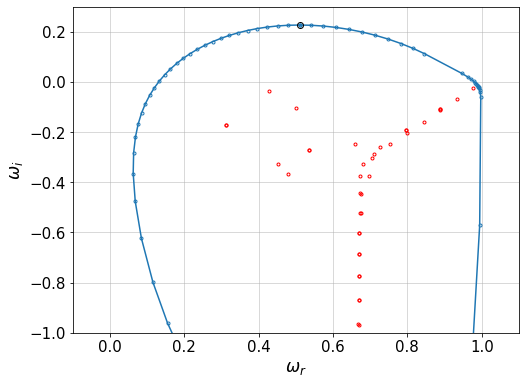

In [44]:
plt.plot(np.real(numrang),np.imag(numrang),'.-')
plt.plot(np.real(omrel),np.imag(omrel),'r.')
plt.plot(np.real(numrang[0]),np.imag(numrang[0]),'ko')
plt.xlim([-0.1,alpha*1.1])
plt.ylim([-1,0.3])
plt.grid()
plt.xlabel('$\omega_r$')
plt.ylabel('$\omega_i$')
plt.show()

The connection between the numerical range and the numerical abscissa is that the largest imaginary values of the numerical range corresponds to the numerical abscissa $\lambda_0 / 2$.

In [45]:
np.imag(numrang[0])*2, lam[0]

(0.45346063044623275, 0.4534606304462338)

### Resolvent norm and pseudospectra

Assume a forced system,

$$\frac{\partial q}{\partial t} = L q + f$$

with a harmonic forcing $f=\hat{f} \exp i \omega t$. We can then find the particular solution as

$$\hat{q}_p = (i \omega - L)^{-1} \hat{f} = R(\omega) \hat{f} \ ,$$

which defines the resolvent operator. Its norm is particularly relevant,

$$ R_N(\omega) = || (i\omega -L )^{-1} || \ , $$

as it describes the potential growth of energy due to the forcing.

Using the Orr-Sommerfeld system with the particular energy norm, we get

$$R_N(\omega) = || F (\omega_{rel} - \omega)^{-1} F^{-1} || \ ,$$

with the eigenvalues $\omega_{rel}$ of the reduced system  $L=F \omega_{rel} F^{-1}$.





In [46]:
N_om = 50
OMr,OMi = np.meshgrid(np.linspace(-0.2,1.2,N_om),np.linspace(-1,0.5,N_om))
resnorm=np.zeros((N_om,N_om))
resnorm0=np.zeros(N_om)

for ii in range(N_om):
    for jj in range(N_om):
        omc = OMr[jj,ii] + 1j*OMi[jj,ii]
        resd = 1./(omrel-omc)
        resnorm[jj,ii]=np.linalg.norm(F@np.diag(resd)@Finv,ord=2)      
        
for ii in range(N_om):    
    omc=OMr[0,ii]
    resd = 1./(omrel-omc)
    resnorm0[ii]=np.linalg.norm(F@np.diag(resd)@Finv,ord=2)

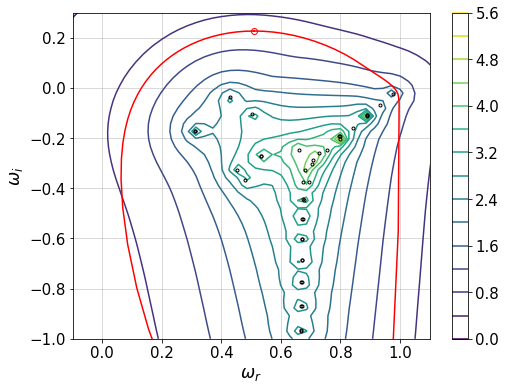

In [47]:
CS=plt.contour(OMr[0,:],OMi[:,0],np.log10(resnorm),levels=15)
plt.colorbar()
plt.plot(np.real(omrel),np.imag(omrel),'k.')
plt.plot(np.real(numrang),np.imag(numrang),'r-')
plt.plot(np.real(numrang[0]),np.imag(numrang[0]),'ro')
plt.xlim([-0.1,alpha*1.1])
plt.ylim([-1,0.3])
plt.grid()
plt.xlabel('$\omega_r$')
plt.ylabel('$\omega_i$')
#plt.colorbar()
plt.show()

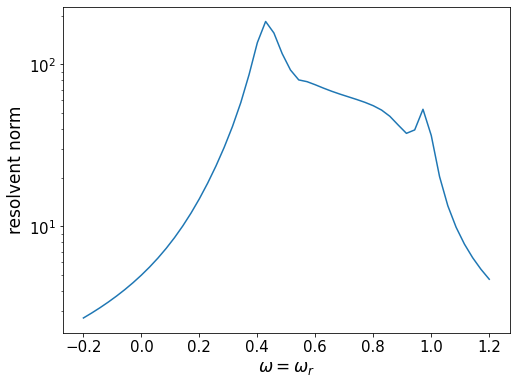

In [48]:
plt.semilogy(OMr[0,:],resnorm0)
plt.xlabel('$\omega = \omega_r$')
plt.ylabel('resolvent norm')
plt.show()

Now we plot the $\varepsilon$-pseudospectrum, which is defined as the minimum singluar value of $A-z I$ being lower than $\varepsilon$. It turns out that this condition is equivalent to the inverse of the residual norm at level $\varepsilon$. The below plot shows colours of the pseudospectrum, with a black contour at $\varepsilon=10^{-3}$:

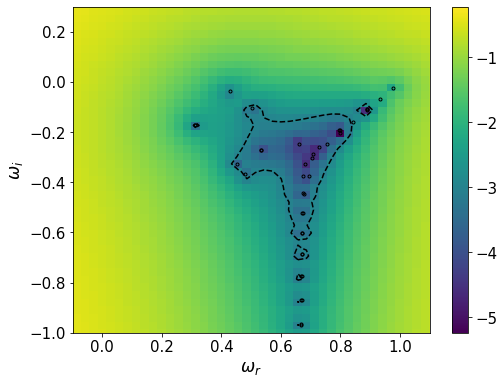

In [49]:
pspec = 1./resnorm
plt.pcolor(OMr[0,:],OMi[:,0],np.log10(pspec),shading='nearest')
plt.colorbar()
plt.contour(OMr[0,:],OMi[:,0],np.log10(pspec),levels=[-3],colors='k')
plt.plot(np.real(omrel),np.imag(omrel),'k.')
plt.xlim([-0.1,alpha*1.1])
plt.ylim([-1,0.3])
#plt.grid()
plt.xlabel('$\omega_r$')
plt.ylabel('$\omega_i$')
plt.show()

---
## 5. Neutral curves

The aim is to compute the contours of the maximum $imag(c)$ for given ranges of $Re$ and $\alpha$. Of particular interest is the isoline of $max(imag(c))=0$ which specifies the **neutral stability curve**. In what follows we limit ourselves to $\beta=0$ which is well motivated by the Squires theorem saying that 2D waves are most dangerous.

First, we compute $max(imag(c))$ for any $(Re,\alpha)$ in a mesh.

In [50]:
N_Re=21
N_alpha=20
RE,ALPHA = np.meshgrid(np.linspace(1000,40000,N_Re),np.linspace(0.5,1.2,N_alpha))

g1=np.zeros((N_Re,N_alpha))

for ii in range(N_Re):
    for jj in range(N_alpha):
        ReN=RE[jj,ii]
        alphaN=ALPHA[jj,ii]

        delta = (D2-I*alphaN**2)
        delta2 = D4-2*D2*alphaN**2+I*alphaN**4
        AN = -delta2/ReN - 1j*alphaN*np.diag(Uvel[:,2]) + 1j*alphaN*np.diag(Uvel[:,0])@delta
        BN = 1j*delta
        
        QN=0.5*D.T @ W @ D/alpha**2 + 0.5*W
        
        Qeig=-999j
        AN[0,:] = Qeig*I[0,:]
        BN[0,:] = I[0,:]
        AN[-1,:]  = Qeig*I[-1,:]
        BN[-1,:] = I[-1,:]
        AN[1,:] = Qeig*D[0,:]
        BN[1,:] = D[0,:]
        AN[-2,:] = Qeig*D[-1,:]
        BN[-2,:] = D[-1,:]
        
        LcN=np.linalg.inv(BN) @ AN
        omegaN,UN = np.linalg.eig(LcN)
        g1[ii,jj]=np.max(omegaN.imag)

and then we plot the contours:

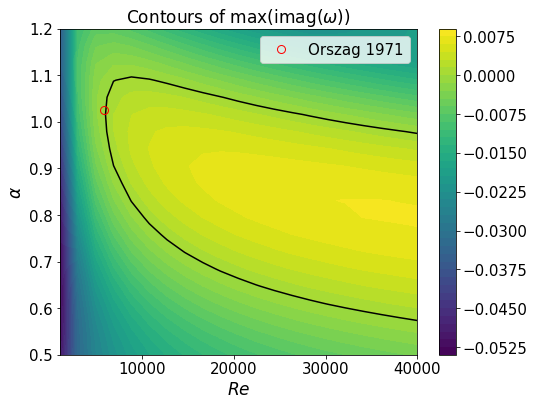

In [51]:
#plt.figure()
CS=plt.contourf((RE[0,:]),(ALPHA[:,0]),g1.T,levels=40)
plt.colorbar()
CS1=plt.contour((RE[0,:]),(ALPHA[:,0]),g1.T,levels=[0],colors='k')
plt.plot(5772,1.0255,'ro',ms=8,label="Orszag 1971") # Orszag 1971
plt.title('Contours of max(imag($\omega$))')
plt.xlabel('$Re$')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.show()

Now let's also compute the numerical abscissa:

In [52]:
N_Re=21
N_alpha=20
RE,ALPHA = np.meshgrid(np.linspace(10,300,N_Re),np.linspace(0.1,2,N_alpha))

g2=np.zeros((N_Re,N_alpha))
imax = 30

for ii in range(N_Re):
    for jj in range(N_alpha):
        ReN=RE[jj,ii]
        alphaN=ALPHA[jj,ii]

        delta = (D2-I*alphaN**2)
        delta2 = D4-2*D2*alphaN**2+I*alphaN**4
        AN = -delta2/ReN - 1j*alphaN*np.diag(Uvel[:,2]) + 1j*alphaN*np.diag(Uvel[:,0])@delta
        BN = 1j*delta
        
        QN=0.5*D.T @ W @ D/alpha**2 + 0.5*W
        
        Qeig=-999j
        AN[0,:] = Qeig*I[0,:]
        BN[0,:] = I[0,:]
        AN[-1,:]  = Qeig*I[-1,:]
        BN[-1,:] = I[-1,:]
        AN[1,:] = Qeig*D[0,:]
        BN[1,:] = D[0,:]
        AN[-2,:] = Qeig*D[-1,:]
        BN[-2,:] = D[-1,:]
        
        LcN=np.linalg.inv(BN) @ AN
        omegaN,UN = np.linalg.eig(LcN)
        isort=np.argsort(-np.imag(omegaN))
        omegaN=omegaN[isort]
        UN=UN[:,isort]
        UrelN = UN[:,0:imax]
        omrelN = omegaN[0:imax]
        EN = UrelN.conj().T @ QN @ UrelN
        
        Uexp, Sexp, Vexp = np.linalg.svd(EN)
        FN    = np.diag(np.sqrt(Sexp))@Uexp.conj().T
        FinvN = Uexp@np.diag(1./np.sqrt(Sexp))

        LN=FN@np.diag(omrelN)@FinvN
        
        lamN,vv = np.linalg.eig( ( (-1j*LN)+(-1j*LN).conj().T) )
        lamN = np.real(lamN)
        
        g2[ii,jj]=np.max(lamN)

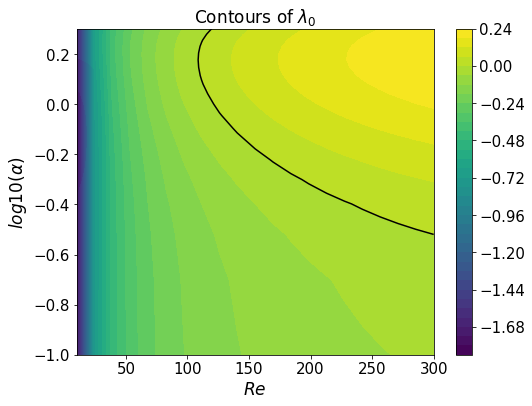

In [53]:
#plt.figure()
CS=plt.contourf((RE[0,:]),np.log10(ALPHA[:,0]),g2.T,levels=40)
plt.colorbar()
CS1=plt.contour((RE[0,:]),np.log10(ALPHA[:,0]),g2.T,levels=[0],colors='k')
plt.title('Contours of $\lambda_0$')
plt.xlabel('$Re$')
plt.ylabel(r'$log10(\alpha)$')
plt.show()